# Understanding Advantage Actor-Critic (A2C): A Complete Guide

# Table of Contents

- [Introduction](#introduction)
- [What is Actor-Critic?](#what-is-actor-critic)
- [What is A2C?](#what-is-a2c)
  - [Synchronous vs. Asynchronous (A3C)](#synchronous-vs-asynchronous-a3c)
  - [Why Use Advantages?](#why-use-advantages)
- [Where and How A2C is Used](#where-and-how-a2c-is-used)
- [Mathematical Foundation of A2C](#mathematical-foundation-of-a2c)
  - [Actor Update (Policy Gradient with Advantage)](#actor-update-policy-gradient-with-advantage)
  - [Critic Update (Value Function Estimation)](#critic-update-value-function-estimation)
  - [Advantage Estimation (n-step or GAE)](#advantage-estimation-n-step-or-gae)
  - [Entropy Bonus](#entropy-bonus)
  - [Combined Loss](#combined-loss)
- [Step-by-Step Explanation of A2C](#step-by-step-explanation-of-a2c)
- [Key Components of A2C](#key-components-of-a2c)
  - [Policy Network (Actor)](#policy-network-actor)
  - [Value Network (Critic)](#value-network-critic)
  - [Rollout Collection (On-Policy, Batched)](#rollout-collection-on-policy-batched)
  - [Advantage Estimation](#advantage-estimation)
  - [Combined Actor-Critic Loss](#combined-actor-critic-loss)
  - [Synchronous Updates](#synchronous-updates)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Grid World](#practical-example-custom-grid-world)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Environment](#creating-the-custom-environment)
- [Implementing the A2C Algorithm](#implementing-the-a2c-algorithm)
  - [Defining the Actor Network](#defining-the-actor-network)
  - [Defining the Critic Network](#defining-the-critic-network)
  - [Calculating Returns and Advantages (using GAE)](#calculating-returns-and-advantages-using-gae)
  - [The A2C Update Step](#the-a2c-update-step)
- [Running the A2C Algorithm](#running-the-a2c-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policy (Optional Visualization)](#analyzing-the-learned-policy-optional-visualization)
- [Common Challenges and Solutions in A2C](#common-challenges-and-solutions-in-a2c)
- [Conclusion](#conclusion)

## Introduction

Actor-Critic methods are a family of reinforcement learning algorithms that combine the strengths of both policy-based methods (like REINFORCE) and value-based methods (like Q-learning). They maintain two distinct components: an Actor, which learns and executes the policy, and a Critic, which learns a value function to evaluate the states or state-action pairs visited by the actor. Advantage Actor-Critic (A2C) is a popular and effective synchronous variant of these methods.

## What is Actor-Critic?

The core idea is to use the Critic's value estimates to improve the Actor's policy updates. Instead of using the high-variance Monte Carlo return $G_t$ (as in REINFORCE) to weight the policy gradient $\nabla_\theta \log \pi_\theta(a_t|s_t)$, actor-critic methods use a lower-variance signal derived from the Critic.

- **Actor:** A policy network $\pi(a|s; \theta)$ that outputs action probabilities (or determines actions directly).
- **Critic:** A value network (e.g., $V(s; \phi)$ or $Q(s, a; \phi)$) that estimates how good a state or state-action pair is.

The Critic learns from the temporal difference (TD) errors based on the rewards received, and the Actor updates its policy in the direction suggested by the Critic's evaluations (often using the TD error or the Advantage function as the scaling factor for the policy gradient).

## What is A2C?

Advantage Actor-Critic (A2C) is a specific implementation strategy for actor-critic methods. Its key features are:

1.  **Advantage Function:** It explicitly uses the *advantage function* $A(s_t, a_t) = Q(s_t, a_t) - V(s_t)$ to update the policy. Intuitively, $A(s_t, a_t)$ measures *how much better* taking action $a_t$ in state $s_t$ is compared to the average action from that state according to the current policy.
2.  **State-Value Critic:** The critic typically learns the state-value function $V(s; \phi)$. The advantage is then estimated using this critic, often via n-step returns or GAE: $\hat{A}_t \approx R_t - V(s_t; \phi)$, where $R_t$ is an estimate of the total return from state $s_t$.
3.  **Synchronous Updates:** Unlike its predecessor A3C (Asynchronous Advantage Actor-Critic), A2C performs updates synchronously. A central controller waits for a batch of experience to be collected (often from multiple parallel workers, though implemented sequentially here) before computing gradients and updating the shared actor and critic networks.

### Synchronous vs. Asynchronous (A3C)
- **A3C:** Uses multiple parallel workers, each with its own copy of the networks and environment. Workers compute gradients independently and asynchronously update a global network. This avoids the need for replay buffers and was thought to decorrelate data.
- **A2C:** Waits for all workers (or a single worker collecting a batch) to finish a segment of experience. Gradients are calculated based on the full batch and applied synchronously. Empirically, A2C often performs as well or better than A3C, is simpler to implement (especially on GPUs), and utilizes hardware more effectively.

### Why Use Advantages?
Using the advantage function $A_t$ instead of the raw return $G_t$ (like REINFORCE) or TD error $\delta_t$ significantly reduces the variance of the policy gradient estimate. Subtracting the state value $V(s_t)$ acts as a baseline, centering the updates around zero. Actions better than average get positive reinforcement, actions worse than average get negative reinforcement, leading to more stable and efficient learning.

## Where and How A2C is Used

A2C is a strong baseline algorithm used in various RL domains:

1.  **Classic Control & Benchmarks:** Effective on tasks like CartPole, Pendulum, Acrobot.
2.  **Atari Games:** Can achieve good performance, though often surpassed by more advanced methods like PPO or Rainbow.
3.  **Continuous Control:** Applicable with appropriate policy distributions (e.g., Gaussian).
4.  **Foundation:** Serves as a simpler synchronous counterpart to A3C and shares many concepts with PPO.

A2C is suitable when:
- A balance between the simplicity of REINFORCE and the complexity/performance of PPO/TRPO is desired.
- On-policy interaction is feasible.
- Lower variance updates than REINFORCE are needed.
- Synchronous updates are preferred over asynchronous ones (easier debugging, better GPU utilization).

## Mathematical Foundation of A2C

A2C aims to optimize both the actor (policy $\pi_	heta$) and the critic (value function $V_\phi$).

### Actor Update (Policy Gradient with Advantage)
The actor parameters $\theta$ are updated using gradient ascent on the policy objective $J(\theta)$. The gradient is estimated using the advantage provided by the critic:
$$ \nabla_\theta J(\theta) \approx \mathbb{E}_t [ \nabla_\theta \log \pi_\theta(a_t | s_t) \hat{A}_t ] $$
where $\hat{A}_t$ is the estimated advantage for the state-action pair $(s_t, a_t)$ taken at time $t$.
The update rule encourages actions that lead to positive advantages and discourages those leading to negative advantages.

### Critic Update (Value Function Estimation)
The critic parameters $\phi$ are updated to minimize the error between the predicted state value $V_\phi(s_t)$ and a target value $R_t$. The target $R_t$ is typically an estimate of the true value $V^{\pi}(s_t)$, often computed using n-step returns or based on GAE.
The loss function is usually the mean squared error (MSE):
$$ L^{VF}(\phi) = \mathbb{E}_t [ (R_t - V_\phi(s_t))^2 ] $$
Minimizing this loss makes the critic a better predictor of future returns.

### Advantage Estimation (n-step or GAE)
The advantage $\hat{A}_t$ can be estimated in several ways:
1.  **One-step (TD error):** $\hat{A}_t = r_{t+1} + \gamma V_\phi(s_{t+1}) - V_\phi(s_t) = \delta_t$. Simple but can be biased.
2.  **n-step:** $\hat{A}_t = (\sum_{k=0}^{n-1} \gamma^k r_{t+k+1}) + \gamma^n V_\phi(s_{t+n}) - V_\phi(s_t)$. Balances bias and variance based on $n$.
3.  **GAE (Generalized Advantage Estimation):** Commonly used with A2C/PPO for a good bias-variance trade-off, identical to its use in TRPO/PPO.
    $$ \hat{A}^{GAE}_t = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}, \quad \text{where} \quad \delta_t = r_t + \gamma V_\phi(s_{t+1}) - V_\phi(s_t) $$
    The target for the critic update when using GAE is often $R_t = \hat{A}^{GAE}_t + V_\phi(s_t)$.

### Entropy Bonus
Similar to PPO, an entropy bonus is often added to the actor's objective to encourage exploration:
$$ J_{entropy}(\theta) = \mathbb{E}_t [ H(\pi_	heta(\cdot|s_t)) ] = \mathbb{E}_t [ \mathbb{E}_{a \sim \pi_	heta(\cdot|s_t)} [-\log \pi_	heta(a|s_t)] ] $$

### Combined Loss
The updates for actor and critic are often performed simultaneously using a combined loss function. Assuming gradient ascent for the actor objective and gradient descent for the critic loss, the overall loss to *minimize* is:
$$ L^{A2C}(\theta, \phi) = \mathbb{E}_t [ -\log \pi_\theta(a_t | s_t) \hat{A}_t^{\text{detached}} - c_e H(\pi_	heta(\cdot|s_t)) + c_v (R_t - V_\phi(s_t))^2 ] $$
Where $c_e$ and $c_v$ are coefficients for the entropy bonus and value loss, respectively. Note that $\hat{A}_t$ is treated as a constant (detached) when computing the policy gradient to avoid interfering gradients.

## Step-by-Step Explanation of A2C

1.  **Initialize**: Actor network $\pi(a|s; \theta)$, Critic network $V(s; \phi)$, hyperparameters ($\gamma, \lambda$, learning rates $\alpha_	heta, \alpha_\phi$, entropy coeff $c_e$, value coeff $c_v$, rollout length $N$).
2.  **For each iteration**:
    a.  **Collect Trajectories**: Run the current policy $\pi_	heta$ for $N$ steps (or across multiple parallel environments for $N$ total steps), collecting $(s_t, a_t, r_{t+1}, s_{t+1}, d_t, \log \pi_	heta(a_t|s_t))$ for $t=0...N-1$. If the last state $s_N$ is not terminal, bootstrap its value $V_\phi(s_N)$.
    b.  **Estimate Advantages & Returns**: Compute $\hat{A}_t$ (e.g., using GAE) and target returns $R_t = \hat{A}_t + V_\phi(s_t)$ for $t=0...N-1$ using the collected rewards and value estimates $V_\phi(s_t)$.
    c.  **Compute Combined Loss**: Calculate the A2C loss $L^{A2C}$ over the collected batch using current network outputs (log probs, entropy, predicted values) and the calculated targets (advantages, returns-to-go).
    d.  **Update Networks**: Perform a single gradient descent step on $L^{A2C}$ to update both $\theta$ and $\phi$ (using separate optimizers or a shared one if applicable).
3.  **Repeat**: Until convergence.

## Key Components of A2C

### Policy Network (Actor)
- Learns the policy $\pi(a|s; \theta)$. Updated based on advantage estimates.

### Value Network (Critic)
- Learns the state-value function $V(s; \phi)$. Provides baseline for advantage calculation and target values.
- Updated based on TD errors or returns-to-go.

### Rollout Collection (On-Policy, Batched)
- Collects a batch of experience (typically fixed number of steps $N$) using the current policy.

### Advantage Estimation
- Computes $\hat{A}_t = R_t - V(s_t)$, often using GAE for $R_t$ (implicitly via $\hat{A}^{GAE}_t$). Provides a variance-reduced signal for policy updates.

### Combined Actor-Critic Loss
- Integrates policy gradient loss (weighted by advantages), value function loss (MSE), and entropy bonus into a single objective for optimization.

### Synchronous Updates
- All gradients from the batch are computed and applied together, simplifying implementation and debugging compared to A3C.

### Hyperparameters
- Learning rates for actor and critic.
- Discount factor $\gamma$.
- GAE $\lambda$ (if used).
- Rollout length $N$.
- Entropy coefficient $c_e$.
- Value loss coefficient $c_v$.

## Practical Example: Custom Grid World

We continue with the custom Grid World environment to maintain consistency and demonstrate A2C's mechanics in a simple setting.

**Environment Description:** (Same as before)
- Grid Size: 10x10.
- State: `[row/9, col/9]`
- Actions: 4 discrete (Up, Down, Left, Right).
- Start: (0, 0), Goal: (9, 9).
- Rewards: +10 (goal), -1 (wall), -0.1 (step).
- Termination: Goal or max steps.


# Setting up the Environment

Import libraries.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque 
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cpu


# Creating the Custom Environment

Using the same `GridEnvironment` class.

In [2]:
# Custom Grid World Environment (Identical to previous notebooks)
class GridEnvironment:
    """
    A simple 10x10 Grid World environment.
    State: (row, col) represented as normalized vector [row/9, col/9].
    Actions: 0 (up), 1 (down), 2 (left), 3 (right).
    Rewards: +10 for reaching the goal, -1 for hitting a wall, -0.1 for each step.
    """
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1)
        self.state: Tuple[int, int] = self.start_state
        self.state_dim: int = 2
        self.action_dim: int = 4
        self.action_map: Dict[int, Tuple[int, int]] = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

    def reset(self) -> torch.Tensor:
        self.state = self.start_state
        return self._get_state_tensor(self.state)

    def _get_state_tensor(self, state_tuple: Tuple[int, int]) -> torch.Tensor:
        norm_row = state_tuple[0] / (self.rows - 1) if self.rows > 1 else 0.0
        norm_col = state_tuple[1] / (self.cols - 1) if self.cols > 1 else 0.0
        normalized_state: List[float] = [norm_row, norm_col]
        return torch.tensor(normalized_state, dtype=torch.float32, device=device)

    def step(self, action: int) -> Tuple[torch.Tensor, float, bool]:
        if self.state == self.goal_state:
            return self._get_state_tensor(self.state), 0.0, True
        dr, dc = self.action_map[action]
        current_row, current_col = self.state
        next_row, next_col = current_row + dr, current_col + dc
        reward: float = -0.1
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = current_row, current_col
            reward = -1.0
        self.state = (next_row, next_col)
        next_state_tensor: torch.Tensor = self._get_state_tensor(self.state)
        done: bool = (self.state == self.goal_state)
        if done:
            reward = 10.0
        return next_state_tensor, reward, done

    def get_action_space_size(self) -> int:
        return self.action_dim

    def get_state_dimension(self) -> int:
        return self.state_dim

Instantiate and test the environment.

In [3]:
custom_env = GridEnvironment(rows=10, cols=10)
n_actions_custom = custom_env.get_action_space_size()
n_observations_custom = custom_env.get_state_dimension()

print(f"Custom Grid Environment:")
print(f"Size: {custom_env.rows}x{custom_env.cols}")
print(f"State Dim: {n_observations_custom}")
print(f"Action Dim: {n_actions_custom}")
start_state_tensor = custom_env.reset()
print(f"Example state tensor for (0,0): {start_state_tensor}")

Custom Grid Environment:
Size: 10x10
State Dim: 2
Action Dim: 4
Example state tensor for (0,0): tensor([0., 0.])


# Implementing the A2C Algorithm

Define the Actor and Critic networks, GAE calculation, and the combined A2C update function.

### Defining the Actor Network

Outputs action probabilities.

In [4]:
# Define the Policy Network (Actor)
class PolicyNetwork(nn.Module):
    """ MLP Actor network for A2C """
    def __init__(self, n_observations: int, n_actions: int):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x: torch.Tensor) -> Categorical:
        """ Forward pass, returns a Categorical distribution. """
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        action_logits = self.layer3(x)
        return Categorical(logits=action_logits)

### Defining the Critic Network

Outputs a single state value estimate.

In [5]:
# Define the Value Network (Critic)
class ValueNetwork(nn.Module):
    """ MLP Critic network for A2C """
    def __init__(self, n_observations: int):
        super(ValueNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Forward pass, returns the estimated state value. """
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        state_value = self.layer3(x)
        return state_value

### Calculating Returns and Advantages (using GAE)

Reusing the GAE function. Note that we also need the returns-to-go ($R_t$) as the target for the critic update.

In [6]:
def compute_gae_and_returns(rewards: torch.Tensor, 
                            values: torch.Tensor, 
                            next_values: torch.Tensor, 
                            dones: torch.Tensor, 
                            gamma: float, 
                            lambda_gae: float, 
                            standardize_adv: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes Generalized Advantage Estimation (GAE) and the returns-to-go (value targets).

    Parameters:
    - rewards, values, next_values, dones: Tensors collected from rollout.
    - gamma (float): Discount factor.
    - lambda_gae (float): GAE smoothing parameter.
    - standardize_adv (bool): Whether to standardize advantages.

    Returns:
    - Tuple[torch.Tensor, torch.Tensor]: 
        - advantages: Tensor of GAE advantages.
        - returns_to_go: Tensor of target values for the critic (Advantage + V_old).
    """
    advantages = torch.zeros_like(rewards)
    last_advantage = 0.0
    n_steps = len(rewards)

    # Calculate advantages using GAE formula backwards
    for t in reversed(range(n_steps)):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_values[t] * mask - values[t]
        advantages[t] = delta + gamma * lambda_gae * last_advantage * mask
        last_advantage = advantages[t]

    # Calculate returns-to-go (targets for value function)
    returns_to_go = advantages + values # R_t = A_t + V(s_t)

    # Standardize advantages (optional but usually recommended)
    if standardize_adv:
        mean_adv = torch.mean(advantages)
        std_adv = torch.std(advantages) + 1e-8
        advantages = (advantages - mean_adv) / std_adv
        
    return advantages, returns_to_go

### The A2C Update Step

This function computes the combined loss for actor and critic and performs a single optimization step.

In [7]:
def update_a2c(actor: PolicyNetwork,
               critic: ValueNetwork,
               actor_optimizer: optim.Optimizer,
               critic_optimizer: optim.Optimizer, # Separate optimizers common
               states: torch.Tensor,
               actions: torch.Tensor,
               advantages: torch.Tensor,
               returns_to_go: torch.Tensor,
               value_loss_coeff: float,
               entropy_coeff: float) -> Tuple[float, float, float]:
    """
    Performs one synchronous update step for both Actor and Critic.

    Parameters:
    - actor, critic: The networks.
    - actor_optimizer, critic_optimizer: The optimizers.
    - states, actions, advantages, returns_to_go: Batch data tensors.
    - value_loss_coeff (float): Coefficient for the value loss.
    - entropy_coeff (float): Coefficient for the entropy bonus.

    Returns:
    - Tuple[float, float, float]: Policy loss, value loss, and entropy for this update step.
    """
    # --- Evaluate current networks --- 
    policy_dist = actor(states)
    log_probs = policy_dist.log_prob(actions)
    entropy = policy_dist.entropy().mean()
    values_pred = critic(states).squeeze()

    # --- Calculate Losses --- 
    # Policy Loss (Actor): - E[log_pi * A] - entropy_bonus
    # Advantages are detached as they shouldn't propagate gradients to the critic here
    policy_loss = -(log_probs * advantages.detach()).mean() - entropy_coeff * entropy
    
    # Value Loss (Critic): MSE(V_pred, R_target)
    # Returns-to-go are detached as they are targets
    value_loss = F.mse_loss(values_pred, returns_to_go.detach())
    
    # Combined loss (optional, can also optimize separately)
    # total_loss = policy_loss + value_loss_coeff * value_loss

    # --- Optimize Actor --- 
    actor_optimizer.zero_grad()
    policy_loss.backward() # Computes gradients only for actor parameters
    actor_optimizer.step()

    # --- Optimize Critic --- 
    critic_optimizer.zero_grad()
    # Need to scale value loss *before* backward if using combined loss and single backward()
    # If optimizing separately, backward() uses the unscaled loss.
    (value_loss_coeff * value_loss).backward() # Computes gradients only for critic parameters
    critic_optimizer.step()

    # Return individual loss components for logging
    return policy_loss.item() + entropy_coeff * entropy.item(), value_loss.item(), entropy.item()
    # Return the policy objective part (-log_pi*A), the value loss, and the entropy

# Running the A2C Algorithm

Set up hyperparameters, initialize networks/optimizers, and run the A2C training loop.

### Hyperparameter Setup

Define A2C hyperparameters.

In [8]:
# Hyperparameters for A2C on Custom Grid World
GAMMA_A2C = 0.99             # Discount factor
GAE_LAMBDA_A2C = 0.95        # GAE lambda parameter
ACTOR_LR_A2C = 3e-4          # Learning rate for the actor
CRITIC_LR_A2C = 1e-3         # Learning rate for the critic
VALUE_LOSS_COEFF_A2C = 0.5   # Coefficient for value loss
ENTROPY_COEFF_A2C = 0.01     # Coefficient for entropy bonus
STANDARDIZE_ADV_A2C = True   # Whether to standardize advantages

NUM_ITERATIONS_A2C = 400    # Number of A2C updates (iterations)
STEPS_PER_ITERATION_A2C = 256 # Number of steps (batch size) collected per iteration
MAX_STEPS_PER_EPISODE_A2C = 200 # Max steps per episode

### Initialization

Initialize actor, critic, and their optimizers.

In [9]:
# Re-instantiate the environment
custom_env: GridEnvironment = GridEnvironment(rows=10, cols=10)
n_actions_custom: int = custom_env.get_action_space_size()
n_observations_custom: int = custom_env.get_state_dimension()

# Initialize Actor and Critic
actor_a2c: PolicyNetwork = PolicyNetwork(n_observations_custom, n_actions_custom).to(device)
critic_a2c: ValueNetwork = ValueNetwork(n_observations_custom).to(device)

# Initialize Optimizers
actor_optimizer_a2c: optim.Adam = optim.Adam(actor_a2c.parameters(), lr=ACTOR_LR_A2C)
critic_optimizer_a2c: optim.Adam = optim.Adam(critic_a2c.parameters(), lr=CRITIC_LR_A2C)

# Lists for plotting
a2c_iteration_rewards = []
a2c_iteration_avg_ep_lens = []
a2c_iteration_policy_losses = []
a2c_iteration_value_losses = []
a2c_iteration_entropies = []

### Training Loop

The A2C training loop: collect a batch of N steps, compute advantages/returns, perform one update for actor and critic.

In [10]:
print("Starting A2C Training on Custom Grid World...")

# --- A2C Training Loop ---
current_state = custom_env.reset() # Start with initial state

for iteration in range(NUM_ITERATIONS_A2C):
    # --- 1. Collect Trajectories (N steps) --- 
    batch_states_list: List[torch.Tensor] = []
    batch_actions_list: List[int] = []
    batch_log_probs_list: List[torch.Tensor] = []
    batch_rewards_list: List[float] = []
    batch_values_list: List[torch.Tensor] = [] # Store V(s_t)
    batch_dones_list: List[float] = []
    
    episode_rewards_in_iter: List[float] = []
    episode_lengths_in_iter: List[int] = []
    current_episode_reward = 0.0
    current_episode_length = 0

    for step in range(STEPS_PER_ITERATION_A2C):
        state_tensor = current_state
        
        # Sample action and get value estimate
        with torch.no_grad():
            policy_dist = actor_a2c(state_tensor)
            value_estimate = critic_a2c(state_tensor)
            action_tensor = policy_dist.sample()
            action = action_tensor.item()
            log_prob = policy_dist.log_prob(action_tensor)
            
        # Store data
        batch_states_list.append(state_tensor)
        batch_actions_list.append(action)
        batch_log_probs_list.append(log_prob)
        batch_values_list.append(value_estimate)

        # Interact
        next_state, reward, done = custom_env.step(action)
        
        batch_rewards_list.append(reward)
        batch_dones_list.append(float(done))
        
        current_state = next_state
        current_episode_reward += reward
        current_episode_length += 1
        
        # Handle episode termination within the batch collection
        if done or current_episode_length >= MAX_STEPS_PER_EPISODE_A2C:
            episode_rewards_in_iter.append(current_episode_reward)
            episode_lengths_in_iter.append(current_episode_length)
            current_state = custom_env.reset() # Reset for the next episode
            current_episode_reward = 0.0
            current_episode_length = 0

    # --- End Rollout --- 

    # Bootstrap value for the last state if the episode didn't end
    with torch.no_grad():
        last_value = critic_a2c(current_state).squeeze() # Value of the state we'd start the next step from
        
    # Convert lists to tensors
    states_tensor = torch.stack(batch_states_list).to(device).squeeze(1) # Remove extra dim if added by network
    actions_tensor = torch.tensor(batch_actions_list, dtype=torch.long, device=device)
    log_probs_tensor = torch.stack(batch_log_probs_list).squeeze().to(device)
    rewards_tensor = torch.tensor(batch_rewards_list, dtype=torch.float32, device=device)
    values_tensor = torch.cat(batch_values_list).squeeze().to(device)
    dones_tensor = torch.tensor(batch_dones_list, dtype=torch.float32, device=device)

    # Need next_values for GAE calculation
    # Shift values and append the bootstrapped last_value
    next_values_tensor = torch.cat((values_tensor[1:], last_value.unsqueeze(0)))

    # --- 2. Estimate Advantages & Returns-to-go --- 
    advantages_tensor, returns_to_go_tensor = compute_gae_and_returns(
        rewards_tensor, values_tensor, next_values_tensor, dones_tensor, 
        GAMMA_A2C, GAE_LAMBDA_A2C, standardize_adv=STANDARDIZE_ADV_A2C
    )

    # --- 3. Perform A2C Update --- 
    avg_policy_loss, avg_value_loss, avg_entropy = update_a2c(
        actor_a2c, critic_a2c, actor_optimizer_a2c, critic_optimizer_a2c,
        states_tensor, actions_tensor, advantages_tensor, returns_to_go_tensor,
        VALUE_LOSS_COEFF_A2C, ENTROPY_COEFF_A2C
    )

    # --- Logging --- 
    avg_reward_iter = np.mean(episode_rewards_in_iter) if episode_rewards_in_iter else np.nan
    avg_len_iter = np.mean(episode_lengths_in_iter) if episode_lengths_in_iter else np.nan

    a2c_iteration_rewards.append(avg_reward_iter)
    a2c_iteration_avg_ep_lens.append(avg_len_iter)
    a2c_iteration_policy_losses.append(avg_policy_loss)
    a2c_iteration_value_losses.append(avg_value_loss)
    a2c_iteration_entropies.append(avg_entropy)

    if (iteration + 1) % 50 == 0: # Print less frequently for potentially longer training
        print(f"Iter {iteration+1}/{NUM_ITERATIONS_A2C} | Avg Reward: {avg_reward_iter:.2f} | Avg Len: {avg_len_iter:.1f} | P_Loss: {avg_policy_loss:.4f} | V_Loss: {avg_value_loss:.4f} | Entropy: {avg_entropy:.4f}")

print("Custom Grid World Training Finished (A2C).")

Starting A2C Training on Custom Grid World...
Iter 50/400 | Avg Reward: -1.55 | Avg Len: 60.2 | P_Loss: -0.0259 | V_Loss: 14.3651 | Entropy: 1.3115
Iter 100/400 | Avg Reward: 6.08 | Avg Len: 22.2 | P_Loss: -0.0787 | V_Loss: 20.6416 | Entropy: 0.9647
Iter 150/400 | Avg Reward: 6.54 | Avg Len: 19.7 | P_Loss: -0.0793 | V_Loss: 9.2166 | Entropy: 0.8163
Iter 200/400 | Avg Reward: 6.85 | Avg Len: 19.3 | P_Loss: -0.0320 | V_Loss: 1.6230 | Entropy: 0.7364
Iter 250/400 | Avg Reward: 7.31 | Avg Len: 18.2 | P_Loss: -0.0797 | V_Loss: 1.5631 | Entropy: 0.6973
Iter 300/400 | Avg Reward: 7.53 | Avg Len: 18.0 | P_Loss: -0.0521 | V_Loss: 0.7190 | Entropy: 0.6447
Iter 350/400 | Avg Reward: 7.89 | Avg Len: 18.3 | P_Loss: -0.0556 | V_Loss: 0.4610 | Entropy: 0.6319
Iter 400/400 | Avg Reward: 7.89 | Avg Len: 18.2 | P_Loss: -0.0499 | V_Loss: 0.2122 | Entropy: 0.5835
Custom Grid World Training Finished (A2C).


# Visualizing the Learning Process

Plot the results for the A2C agent.

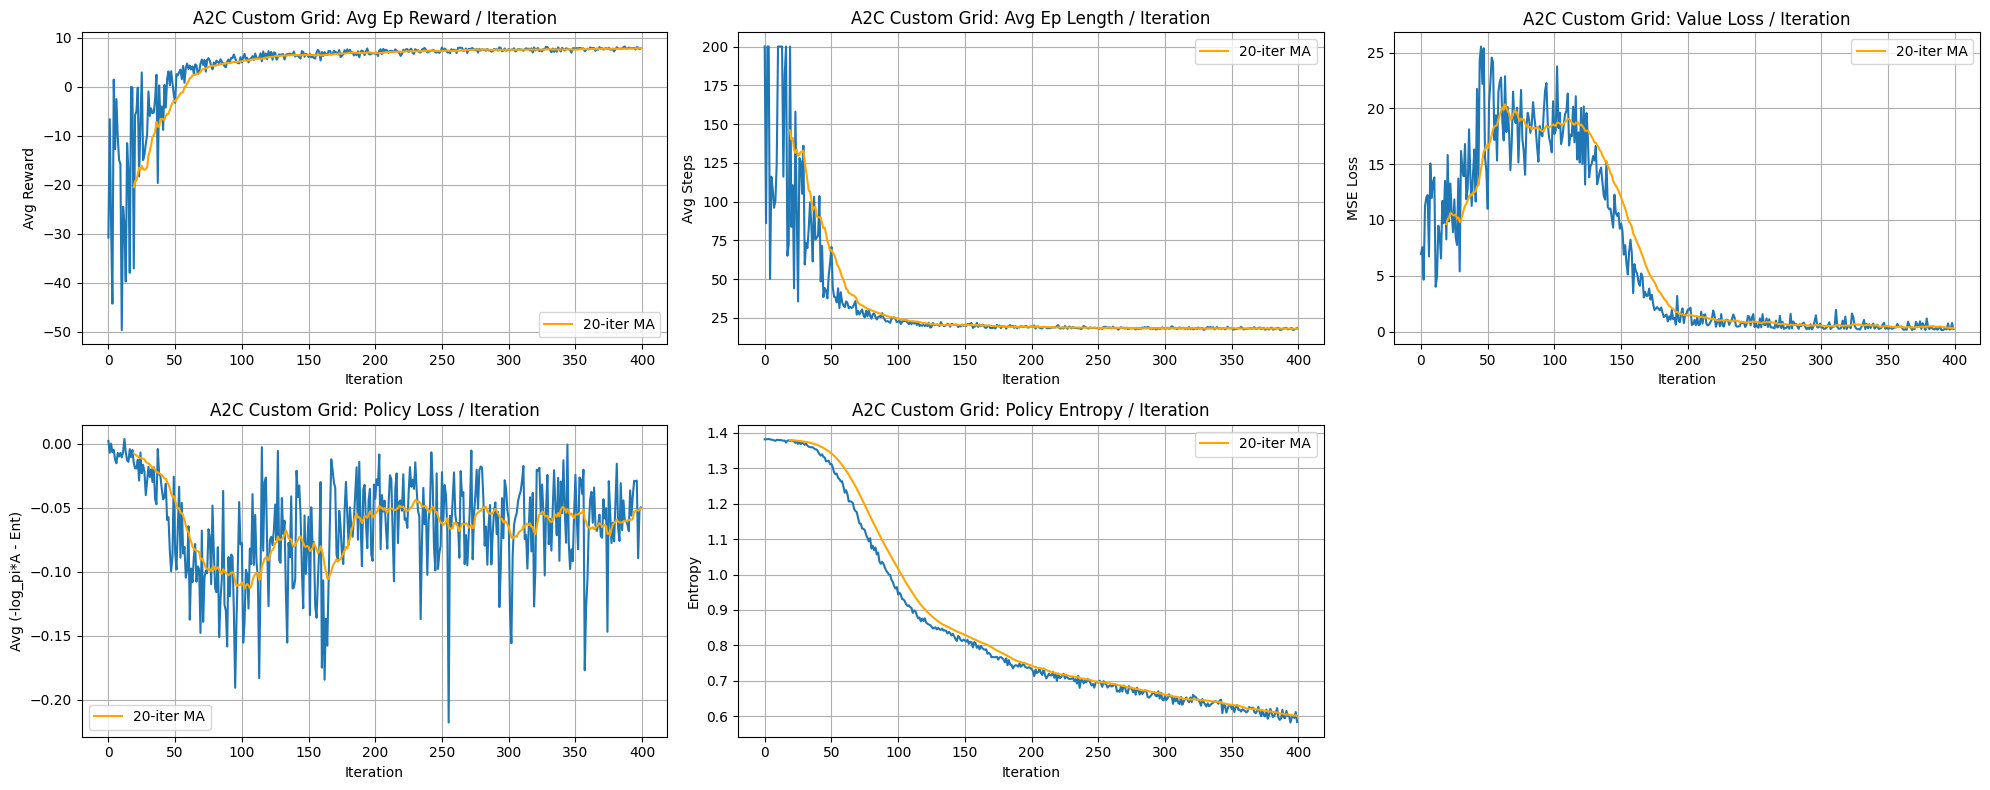

In [11]:
# Plotting results for A2C on Custom Grid World
plt.figure(figsize=(20, 8))

# Average Rewards per Iteration
plt.subplot(2, 3, 1)
valid_rewards_a2c = [r for r in a2c_iteration_rewards if not np.isnan(r)]
valid_indices_a2c = [i for i, r in enumerate(a2c_iteration_rewards) if not np.isnan(r)]
plt.plot(valid_indices_a2c, valid_rewards_a2c)
plt.title('A2C Custom Grid: Avg Ep Reward / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.grid(True)
if len(valid_rewards_a2c) >= 20: # Use larger window for potentially noisy rewards
    rewards_ma_a2c = np.convolve(valid_rewards_a2c, np.ones(20)/20, mode='valid')
    plt.plot(valid_indices_a2c[19:], rewards_ma_a2c, label='20-iter MA', color='orange')
    plt.legend()

# Average Episode Length per Iteration
plt.subplot(2, 3, 2)
valid_lens_a2c = [l for l in a2c_iteration_avg_ep_lens if not np.isnan(l)]
valid_indices_len_a2c = [i for i, l in enumerate(a2c_iteration_avg_ep_lens) if not np.isnan(l)]
plt.plot(valid_indices_len_a2c, valid_lens_a2c)
plt.title('A2C Custom Grid: Avg Ep Length / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg Steps')
plt.grid(True)
if len(valid_lens_a2c) >= 20:
    lens_ma_a2c = np.convolve(valid_lens_a2c, np.ones(20)/20, mode='valid')
    plt.plot(valid_indices_len_a2c[19:], lens_ma_a2c, label='20-iter MA', color='orange')
    plt.legend()

# Critic (Value) Loss per Iteration
plt.subplot(2, 3, 3)
plt.plot(a2c_iteration_value_losses)
plt.title('A2C Custom Grid: Value Loss / Iteration')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.grid(True)
if len(a2c_iteration_value_losses) >= 20:
    vloss_ma_a2c = np.convolve(a2c_iteration_value_losses, np.ones(20)/20, mode='valid')
    plt.plot(np.arange(len(vloss_ma_a2c)) + 19, vloss_ma_a2c, label='20-iter MA', color='orange')
    plt.legend()

# Actor (Policy) Loss per Iteration (Policy Objective Part)
plt.subplot(2, 3, 4)
plt.plot(a2c_iteration_policy_losses)
plt.title('A2C Custom Grid: Policy Loss / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg (-log_pi*A - Ent)')
plt.grid(True)
if len(a2c_iteration_policy_losses) >= 20:
    ploss_ma_a2c = np.convolve(a2c_iteration_policy_losses, np.ones(20)/20, mode='valid')
    plt.plot(np.arange(len(ploss_ma_a2c)) + 19, ploss_ma_a2c, label='20-iter MA', color='orange')
    plt.legend()

# Entropy per Iteration
plt.subplot(2, 3, 5)
plt.plot(a2c_iteration_entropies)
plt.title('A2C Custom Grid: Policy Entropy / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.grid(True)
if len(a2c_iteration_entropies) >= 20:
    entropy_ma_a2c = np.convolve(a2c_iteration_entropies, np.ones(20)/20, mode='valid')
    plt.plot(np.arange(len(entropy_ma_a2c)) + 19, entropy_ma_a2c, label='20-iter MA', color='orange')
    plt.legend()

plt.tight_layout()
plt.show()

**Analysis of A2C Learning Curves (Custom Grid World):**

1.  **Avg Ep Reward / Iteration:**
    The agent learns successfully, with rewards increasing steeply between iterations ~20-100 and then stably plateauing near the optimal value (~8). The curve shows significantly less variance than REINFORCE after convergence, demonstrating the stabilizing effect of the critic's baseline, though perhaps slightly slower initial convergence than PPO/REINFORCE in this run.

2.  **Avg Ep Length / Iteration:**
    Matching the reward trend, episode lengths drop rapidly during the main learning phase (~20-100 iterations) and stabilize cleanly near the optimal path length (~18 steps). This confirms the agent learned an efficient policy alongside maximizing rewards, achieving consistent, quick goal attainment.

3.  **Avg Value Loss / Iteration:**
    The critic's MSE loss initially increases as the policy rapidly changes, then decreases significantly and converges to a very low value. This indicates the value function successfully learned to accurately predict state values for the improving policy, providing a good baseline for advantage calculations and stabilizing the learning process compared to REINFORCE.

4.  **Avg Policy Loss / Iteration:**
    The policy loss (actor's objective, including entropy) decreases substantially (becomes more negative) during learning, signifying effective policy improvement driven by advantage estimates. It exhibits moderate variance, less than REINFORCE but potentially more than PPO's clipped objective. The gradual rise towards zero later might reflect smaller advantages and decreasing entropy near convergence.

5.  **Avg Policy Entropy / Iteration:**
    Entropy starts high, facilitating exploration, and decreases smoothly and steadily throughout training as the policy becomes more deterministic. This controlled reduction shows the agent balancing exploration with exploitation, converging towards a more confident, optimal policy without premature collapse.

**Overall Conclusion:**
A2C effectively solves the Grid World, demonstrating stable learning characteristic of actor-critic methods due to variance reduction via the value baseline. It converges efficiently to a near-optimal policy, balancing reward maximization and path efficiency. The learning curves for loss and entropy show expected behavior, confirming the algorithm's components are working correctly.

# Analyzing the Learned Policy (Optional Visualization)

Visualize the policy learned by the A2C actor network.


Plotting Learned Policy from A2C:


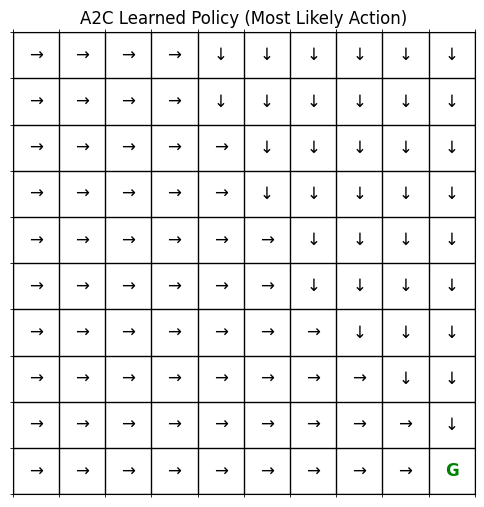

In [12]:
# Reusing the policy plotting function (works for Actor networks outputting Categorical)
def plot_a2c_policy_grid(policy_net: PolicyNetwork, env: GridEnvironment, device: torch.device) -> None:
    """
    Plots the greedy policy derived from the A2C policy network.
    Shows the most likely action for each state.
    (Identical to the REINFORCE/TRPO/PPO plotting function)
    """
    rows: int = env.rows
    cols: int = env.cols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    fig, ax = plt.subplots(figsize=(cols * 0.6, rows * 0.6))

    for r in range(rows):
        for c in range(cols):
            state_tuple: Tuple[int, int] = (r, c)
            if state_tuple == env.goal_state:
                policy_grid[r, c] = 'G'
                ax.text(c, r, 'G', ha='center', va='center', color='green', fontsize=12, weight='bold')
            else:
                state_tensor: torch.Tensor = env._get_state_tensor(state_tuple)
                with torch.no_grad():
                    action_dist: Categorical = policy_net(state_tensor)
                    best_action: int = action_dist.probs.argmax(dim=1).item()

                policy_grid[r, c] = action_symbols[best_action]
                ax.text(c, r, policy_grid[r, c], ha='center', va='center', color='black', fontsize=12)

    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("A2C Learned Policy (Most Likely Action)")
    plt.show()

# Plot the policy learned by the trained A2C actor
print("\nPlotting Learned Policy from A2C:")
plot_a2c_policy_grid(actor_a2c, custom_env, device)

## Common Challenges and Solutions in A2C

**Challenge: Correlated Updates within a Batch**
*   **Problem:** In the synchronous version (especially with a single worker), the batch of $N$ steps comes from a single trajectory segment. These consecutive samples are highly correlated, which can reduce gradient quality and learning stability compared to uncorrelated samples (like DQN's replay buffer) or diverse samples (like A3C's asynchronous updates).
*   **Solutions**:
    *   **Use Multiple Parallel Workers:** The standard A2C implementation often uses multiple environments running in parallel to collect the batch of $N$ steps. This introduces diversity into the batch, decorrelating the data and improving stability.
    *   **Increase Batch Size ($N$):** Larger batches can average out some noise but increase the time between updates.

**Challenge: Sensitivity to Hyperparameters**
*   **Problem:** Performance depends on tuning learning rates, entropy/value coefficients, rollout length ($N$), and GAE parameters.
*   **Solutions**:
    *   **Careful Tuning:** Experiment with values, often starting with common defaults.
    *   **Learning Rate Scheduling:** Decaying learning rates can help stabilize later stages of training.
    *   **Entropy Scheduling:** Sometimes decaying the entropy coefficient $c_e$ is beneficial.

**Challenge: Value Function Accuracy**
*   **Problem:** As with all actor-critic methods using advantage estimates, an inaccurate critic leads to noisy or biased advantage signals, hindering actor learning.
  **Solutions**:
    *   **Tune Critic Learning Rate / Value Coefficient:** Ensure the critic learns effectively without overpowering the policy gradient.
    *   **Multiple Critic Updates per Actor Update:** Sometimes performing more updates on the critic per batch helps it keep up with the changing policy (though less common in basic A2C than in some off-policy methods).

**Challenge: Sample Inefficiency (On-Policy)**
*   **Problem:** Like other on-policy methods, data is discarded after the update.
   **Solutions**:
    *   **PPO:** PPO explicitly allows multiple epochs over the same data, significantly improving sample efficiency over A2C.
    *   **Off-Policy Actor-Critic:** Algorithms like DDPG, TD3, SAC use replay buffers for much greater sample efficiency.

## Conclusion

Advantage Actor-Critic (A2C) is a fundamental and effective actor-critic algorithm. By using a critic to estimate state values and compute advantages, it significantly reduces the gradient variance compared to REINFORCE, leading to more stable and often faster learning. Its synchronous nature makes it easier to implement and utilize hardware like GPUs compared to its asynchronous counterpart, A3C.

A2C serves as a strong baseline and a conceptual bridge towards more advanced methods like PPO. While PPO often offers further improvements in stability and sample efficiency through its clipped objective and multiple update epochs, A2C remains a valuable algorithm for its relative simplicity within the actor-critic family and its clear demonstration of using value functions to improve policy gradients.